# Collect data & Create Database 

In [ ]:
#Step 1: Create Database (In Commandline)
```
sqlite3 mta.db
```
#Step 2: Create the table (In SQL)
```
CREATE TABLE mta_data (CA TEXT,UNIT TEXT,SCP TEXT,STATION TEXT,LINENAME TEXT,DIVISION TEXT,DATE TEXT,TIME TEXT,DESC TEXT,ENTRIES INTEGER,EXITS INTEGER,PRIMARY KEY (CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS));
```

#Step 3: Use python to download all the txt files I need (In Python)
```
import urllib.request
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
week_nums = [210102, 210109, 210116, 210123, 210130, 210206, 210213, 210220, 210227,
210306, 210313, 210320, 210327]

for week_num in week_nums:
    urllib.request.urlretrieve(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week_num}.txt",
                               f"data/turnstile_{week_num}.txt")
```

#Step 4: Combine them into one big csv to load into sqlite (In Commandline)
```
 head -1 turnstile_210102.txt > all_combined.csv
 tail -n +2 -q *.txt >> all_combined.csv
```
 
# Step 5: Go back to sqlite tab; load the big csv into sqlite (In SQL)
```
.mode csv
.import data/all_combined.csv mta_data 
```

# Data Manipulation & Visulization

In [1]:
#import libraries
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set()
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#connect to database and read data into pandas dataframe
engine = create_engine("sqlite:////Users/lixufei/project1/mta.db")
df = pd.read_sql('SELECT * FROM mta_data;', engine)

In [3]:
df.head(5) 

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,03:00:00,REGULAR,7508509,2557569
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,07:00:00,REGULAR,7508511,2557581
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,11:00:00,REGULAR,7508531,2557636
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,15:00:00,REGULAR,7508610,2557667
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/26/2020,19:00:00,REGULAR,7508767,2557689


In [4]:
#EDA: explore whole data frame
df.shape

(2719827, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2719827 entries, 0 to 2719826
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   CA        object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 228.3+ MB


Notes: in describe we can see there's some 0 values in both ENTRIES & EXITS which shouldn't be correct

In [6]:
#check if there's missing value - Nope
df.isna().sum()  

CA          0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

In [7]:
#check if column names are correct, no whitespace - Yeap
df.columns

Index(['CA', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [8]:
#check how many column for each date  -  Length: we have 91 days of data(13 weeks)
df.DATE.value_counts().sort_index()

01/01/2021    30696
01/02/2021    30595
01/03/2021    29807
01/04/2021    29779
01/05/2021    29802
              ...  
12/27/2020    29971
12/28/2020    30150
12/29/2020    29877
12/30/2020    29953
12/31/2020    29976
Name: DATE, Length: 91, dtype: int64

In [9]:
#create 'DATETIME' column & change 'DATE' type to datatime type (or use .astype())
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME, format="%m/%d/%Y %H:%M:%S")
df['DATE'] = pd.to_datetime(df.DATE)
df.head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,03:00:00,REGULAR,7508509,2557569,2020-12-26 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,07:00:00,REGULAR,7508511,2557581,2020-12-26 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,11:00:00,REGULAR,7508531,2557636,2020-12-26 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,15:00:00,REGULAR,7508610,2557667,2020-12-26 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,19:00:00,REGULAR,7508767,2557689,2020-12-26 19:00:00


In [10]:
# Sanity Check: to verify that "CA", "UNIT", "SCP", "STATION", "DATETIME" is unique (no duplicate rows)
#Each combination of CA, UNIT, SCP, and STATION represents a unique turnstile.
(df
 .groupby(["CA", 'UNIT', 'SCP', 'STATION', "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,CA,UNIT,SCP,STATION,DATETIME,ENTRIES
1830837,R145,R032,00-00-02,TIMES SQ-42 ST,2021-02-04 07:00:00,2
832704,N100,R252,00-00-00,HIGH ST,2021-03-09 03:00:00,2
832702,N100,R252,00-00-00,HIGH ST,2021-03-08 19:00:00,2
832701,N100,R252,00-00-00,HIGH ST,2021-03-08 15:00:00,2
832700,N100,R252,00-00-00,HIGH ST,2021-03-08 11:00:00,2


In [11]:
#Let's have a look at 2021-02-04, it seems a duplicated entry
mask = ((df.CA =='R145') & 
        (df.UNIT == 'R032') & 
        (df.SCP =='00-00-02') &
        (df.STATION == 'TIMES SQ-42 ST') & 
        (df.DATETIME.dt.date == datetime.datetime(2021,2,4).date()))
df[mask].head(5)

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
1188850,R145,R032,00-00-02,TIMES SQ-42 ST,1237ACENQRSW,IRT,2021-02-04,03:00:00,REGULAR,6196649,2790991,2021-02-04 03:00:00
1188851,R145,R032,00-00-02,TIMES SQ-42 ST,1237ACENQRSW,IRT,2021-02-04,03:00:00,RECOVR AUD,860254,976394,2021-02-04 03:00:00
1188852,R145,R032,00-00-02,TIMES SQ-42 ST,1237ACENQRSW,IRT,2021-02-04,07:00:00,REGULAR,6196662,2790993,2021-02-04 07:00:00
1188853,R145,R032,00-00-02,TIMES SQ-42 ST,1237ACENQRSW,IRT,2021-02-04,07:00:00,RECOVR AUD,860306,976446,2021-02-04 07:00:00
1188854,R145,R032,00-00-02,TIMES SQ-42 ST,1237ACENQRSW,IRT,2021-02-04,11:00:00,REGULAR,6196696,2791039,2021-02-04 11:00:00


In [12]:
#drop dupicates & filter out bad data by only select 'REGULAR' for 'DESC' column
#check point df_deduped
df_deduped = df.drop_duplicates(subset=['CA', 'UNIT', 'SCP', 'STATION', 'DATETIME'])
df_deduped = df_deduped[df_deduped.DESC == 'REGULAR']
df_deduped

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,03:00:00,REGULAR,7508509,2557569,2020-12-26 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,07:00:00,REGULAR,7508511,2557581,2020-12-26 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,11:00:00,REGULAR,7508531,2557636,2020-12-26 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,15:00:00,REGULAR,7508610,2557667,2020-12-26 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-12-26,19:00:00,REGULAR,7508767,2557689,2020-12-26 19:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2719822,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,05:00:00,REGULAR,5554,544,2021-03-26 05:00:00
2719823,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,09:00:00,REGULAR,5554,544,2021-03-26 09:00:00
2719824,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,13:00:00,REGULAR,5554,544,2021-03-26 13:00:00
2719825,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,17:00:00,REGULAR,5554,544,2021-03-26 17:00:00


In [13]:
df_deduped.DESC.unique()

array(['REGULAR'], dtype=object)

In [14]:
#sanity check again, make sure all column are unique, no duplicates
(df_deduped
 .groupby(["CA", 'UNIT', 'SCP', 'STATION', "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)  

,CA,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2020-12-26 03:00:00,1
1805448,R138,R293,00-03-04,34 ST-PENN STA,2021-01-18 13:00:00,1
1805450,R138,R293,00-03-04,34 ST-PENN STA,2021-01-18 21:00:00,1
1805451,R138,R293,00-03-04,34 ST-PENN STA,2021-01-19 01:00:00,1
1805452,R138,R293,00-03-04,34 ST-PENN STA,2021-01-19 05:00:00,1


In [15]:
#the maximum ENTRIES value for each day, for each unique turnstile.
df_daily = df_deduped.groupby(["CA", 'UNIT', 'SCP', 'STATION', "DATE"],as_index=False).ENTRIES.max()
df_daily

,CA,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,2020-12-26,7508852
1,A002,R051,02-00-00,59 ST,2020-12-27,7509162
2,A002,R051,02-00-00,59 ST,2020-12-28,7509820
3,A002,R051,02-00-00,59 ST,2020-12-29,7510454
4,A002,R051,02-00-00,59 ST,2020-12-30,7511062
...,...,...,...,...,...,...
453556,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-03-22,5554
453557,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-03-23,5554
453558,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-03-24,5554
453559,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-03-25,5554


In [16]:
df_daily[['PREV_DATE','PREV_ENTRIES']] = df_daily.groupby(['CA', 'UNIT', 'SCP', 'STATION'])['DATE', 'ENTRIES'].apply(lambda x: x.shift(1))
df_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
df_daily.head(5)

<ipython-input-16-1690b1ea2682>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_daily[['PREV_DATE','PREV_ENTRIES']] = df_daily.groupby(['CA', 'UNIT', 'SCP', 'STATION'])['DATE', 'ENTRIES'].apply(lambda x: x.shift(1))


,CA,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,2020-12-27,7509162,2020-12-26,7508852.00000
2,A002,R051,02-00-00,59 ST,2020-12-28,7509820,2020-12-27,7509162.00000
3,A002,R051,02-00-00,59 ST,2020-12-29,7510454,2020-12-28,7509820.00000
4,A002,R051,02-00-00,59 ST,2020-12-30,7511062,2020-12-29,7510454.00000
5,A002,R051,02-00-00,59 ST,2021-01-01,7511647,2020-12-30,7511062.00000


In [17]:
#Let's have a look at the turnstile of "TRAM2 	R469 	00-05-01 	RIT-ROOSEVELT"
mask = ((df_daily.CA =='TRAM2') & 
        (df_daily.UNIT == 'R469') & 
        (df_daily.SCP =='00-05-01') &
        (df_daily.STATION == 'RIT-ROOSEVELT'))  

df_daily[mask].tail(100000)

,CA,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
453471,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-27,5554,2020-12-26,5554.00000
453472,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-28,5554,2020-12-27,5554.00000
453473,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-29,5554,2020-12-28,5554.00000
453474,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-30,5554,2020-12-29,5554.00000
453475,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2020-12-31,5554,2020-12-30,5554.00000
...,...,...,...,...,...,...,...,...
453556,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-03-22,5554,2021-03-21,5554.00000
453557,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-03-23,5554,2021-03-22,5554.00000
453558,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-03-24,5554,2021-03-23,5554.00000
453559,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2021-03-25,5554,2021-03-24,5554.00000


Notes: The 'Entries' amount didn't change, we can tell this single turnstile was broken or closed during our 3 month period.

In [18]:
#check wildness
df_daily[df_daily["ENTRIES"] < df_daily["PREV_ENTRIES"]].head()

,CA,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
446,A002,R051,02-03-02,59 ST,2021-03-23,668,2021-03-22,6641481.00000
3535,A011,R080,01-03-00,57 ST-7 AV,2020-12-27,885630589,2020-12-26,885630716.00000
3536,A011,R080,01-03-00,57 ST-7 AV,2020-12-28,885630483,2020-12-27,885630589.00000
3537,A011,R080,01-03-00,57 ST-7 AV,2020-12-29,885630260,2020-12-28,885630483.00000
3538,A011,R080,01-03-00,57 ST-7 AV,2020-12-30,885630026,2020-12-29,885630260.00000


In [19]:
#Let's look into a specific turnstile on a specific day in our original dataset.
## with the time goes by, the ENTRIES decrese
mask = ((df_deduped["CA"] == "A011") & 
(df_deduped["UNIT"] == "R080") & 
(df_deduped["SCP"] == "01-03-00") & 
(df_deduped["STATION"] == "57 ST-7 AV") &
(df_deduped['DATE'] == datetime.datetime(2020, 12, 27))) 
df_deduped[mask].head()

,CA,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
1668,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2020-12-27,03:00:00,REGULAR,885630589,489703552,2020-12-27 03:00:00
1669,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2020-12-27,07:00:00,REGULAR,885630587,489703535,2020-12-27 07:00:00
1670,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2020-12-27,11:00:00,REGULAR,885630579,489703417,2020-12-27 11:00:00
1671,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2020-12-27,15:00:00,REGULAR,885630556,489703296,2020-12-27 15:00:00
1672,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,2020-12-27,19:00:00,REGULAR,885630523,489703162,2020-12-27 19:00:00


In [20]:
(df_daily[df_daily["ENTRIES"] < df_daily["PREV_ENTRIES"]]
    .groupby(["CA", "UNIT", "SCP", "STATION"])
    .size())
#shows how many turnstile has strange rows - 205 turnstiles 

CA    UNIT  SCP       STATION        
A002  R051  02-03-02  59 ST               1
A011  R080  01-03-00  57 ST-7 AV         90
            01-03-01  57 ST-7 AV          1
A025  R023  01-06-00  34 ST-HERALD SQ     1
A031  R083  00-00-01  23 ST               1
                                         ..
R619  R059  00-03-00  GRAND ARMY PLAZ     1
R622  R123  00-00-00  FRANKLIN AV        88
R624  R124  00-00-02  KINGSTON AV         1
R627  R063  00-03-02  SUTTER AV-RUTLD     1
R730  R431  00-00-04  EASTCHSTER/DYRE    90
Length: 205, dtype: int64

In [21]:
#write a function to make our data valid
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

df_daily["DAILY_ENTRIES"] = df_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [22]:
#we want to know the top 10 busiest station, so we sum up all different turnstiles in the same Station.
df_sum_daily = df_daily.groupby(['STATION'])[['DAILY_ENTRIES']].sum().reset_index().rename(columns = {'DAILY_ENTRIES': 'SUM_DAILY_ENTRIES'})
top_10_busiest = df_sum_daily.sort_values('SUM_DAILY_ENTRIES', ascending=False).head(10)
top_10_busiest

,STATION,SUM_DAILY_ENTRIES
59,34 ST-HERALD SQ,2787857.00000
226,FULTON ST,2547960.00000
233,GRD CNTRL-42 ST,2522451.00000
61,34 ST-PENN STA,2443014.00000
352,TIMES SQ-42 ST,2372070.00000
86,59 ST COLUMBUS,2332716.00000
46,23 ST,2215304.00000
9,125 ST,2155655.00000
314,PATH NEW WTC,2096124.00000
110,86 ST,1987660.00000


In [23]:
top_15_busiest = df_sum_daily.sort_values('SUM_DAILY_ENTRIES', ascending=False).head(15)
top_15_busiest

,STATION,SUM_DAILY_ENTRIES
59,34 ST-HERALD SQ,2787857.00000
226,FULTON ST,2547960.00000
233,GRD CNTRL-42 ST,2522451.00000
61,34 ST-PENN STA,2443014.00000
352,TIMES SQ-42 ST,2372070.00000
86,59 ST COLUMBUS,2332716.00000
46,23 ST,2215304.00000
9,125 ST,2155655.00000
314,PATH NEW WTC,2096124.00000
110,86 ST,1987660.00000


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


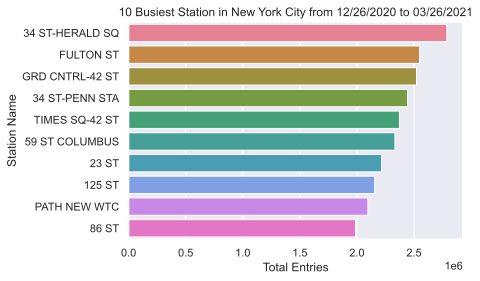

In [24]:
x = top_10_busiest.STATION
y = top_10_busiest.SUM_DAILY_ENTRIES
sns.barplot(y, x, data = top_10_busiest, palette = sns.color_palette("husl", 10))
plt.title('10 Busiest Station in New York City from 12/26/2020 to 03/26/2021')
plt.xlabel('Total Entries')
plt.ylabel('Station Name')
plt.savefig('10_busiest_station_plot.png');

In [25]:
#Part 2: GROUP BY STATION, DAY_OF_WEEK
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448529 entries, 1 to 453560
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CA             448529 non-null  object        
 1   UNIT           448529 non-null  object        
 2   SCP            448529 non-null  object        
 3   STATION        448529 non-null  object        
 4   DATE           448529 non-null  datetime64[ns]
 5   ENTRIES        448529 non-null  int64         
 6   PREV_DATE      448529 non-null  datetime64[ns]
 7   PREV_ENTRIES   448529 non-null  float64       
 8   DAILY_ENTRIES  448529 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 34.2+ MB


In [26]:
df_daily['DAY_OF_WEEK'] = df_daily.DATE.dt.weekday
df_daily.head(5)

,CA,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DAY_OF_WEEK
1,A002,R051,02-00-00,59 ST,2020-12-27,7509162,2020-12-26,7508852.00000,310.00000,6
2,A002,R051,02-00-00,59 ST,2020-12-28,7509820,2020-12-27,7509162.00000,658.00000,0
3,A002,R051,02-00-00,59 ST,2020-12-29,7510454,2020-12-28,7509820.00000,634.00000,1
4,A002,R051,02-00-00,59 ST,2020-12-30,7511062,2020-12-29,7510454.00000,608.00000,2
5,A002,R051,02-00-00,59 ST,2021-01-01,7511647,2020-12-30,7511062.00000,585.00000,4


In [27]:
#Select the 2nd 5 busiest station.
df_daily_select = df_daily[((df_daily['STATION'] =='59 ST COLUMBUS') | (df_daily['STATION'] == '23 ST') | (df_daily['STATION'] == '125 ST') | (df_daily['STATION'] == 'PATH NEW WTC') | (df_daily['STATION'] =='86 ST'))]
df_total_daily = df_daily_select.groupby(['STATION', 'DAY_OF_WEEK'])[['DAILY_ENTRIES']].sum().reset_index().rename(columns = {'DAILY_ENTRIES': 'TOTAL_DAILY_ENTRIES'})
df_total_daily['DAY_OF_WEEK'] = df_total_daily.DAY_OF_WEEK.map({0:'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
df_total_daily

,STATION,DAY_OF_WEEK,TOTAL_DAILY_ENTRIES
0,125 ST,Mon,538224.00000
1,125 ST,Tue,306113.00000
2,125 ST,Wed,318683.00000
3,125 ST,Thu,315282.00000
4,125 ST,Fri,309271.00000
...,...,...,...
30,PATH NEW WTC,Wed,764015.00000
31,PATH NEW WTC,Thu,250004.00000
32,PATH NEW WTC,Fri,180363.00000
33,PATH NEW WTC,Sat,519207.00000


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


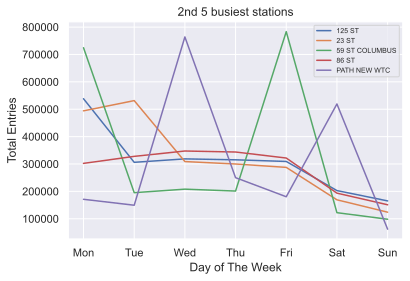

In [28]:
x = df_total_daily.DAY_OF_WEEK
y = df_total_daily.TOTAL_DAILY_ENTRIES
sns.lineplot(x, y, hue = df_total_daily.STATION, data = df_total_daily)
plt.title('2nd 5 busiest stations')
plt.xlabel('Day of The Week')
plt.ylabel('Total Entries')
#plt.xticks(np.arange(7),['Mon','Tu','We','Th','Fr','St','Sn'])
plt.legend(loc=0, prop={'size': 7})
plt.savefig('2nd 5_busiest_station_lineplot.png')

### Notes: 

Before get the conclusion, I checked how far each stations are from the Sephora retail store. 
We don't want it too far because it can save employees' time as well as increase the opportunity for people to stop by the store right after they know the sale info.

6. 59 ST COLUMBUS  - 4 min walk 
7. 23 ST  - 3 min walk
8. 125 ST -  16 minutes drive/45 minutes walk  
9. PATH NEW WTC - 4 minute walk
10. 86 ST  - 5 minutes walk

It seems "125 ST" are too far, which will not be effiency.
So, I am getting next serval station and found "42 ST - Port Auth" is a better choice than "125 ST"

11. Ocean Pkwy - 18 min drive/1 hr 39 min walk
12. 59 ST - 6 min drive/29 min walk
13. 42 ST-PORT AUTH  - 3 minutes walk

In [29]:
#instead of "125 ST", I use "42 ST-PORT AUTH" instead
df_daily_select_update = df_daily[((df_daily['STATION'] =='59 ST COLUMBUS') | (df_daily['STATION'] == '23 ST') | (df_daily['STATION'] == '42 ST-PORT AUTH') | (df_daily['STATION'] == 'PATH NEW WTC') | (df_daily['STATION'] =='86 ST'))]
df_total_daily_update = df_daily_select_update.groupby(['STATION', 'DAY_OF_WEEK'])[['DAILY_ENTRIES']].sum().reset_index().rename(columns = {'DAILY_ENTRIES': 'TOTAL_DAILY_ENTRIES'})
df_total_daily_update

,STATION,DAY_OF_WEEK,TOTAL_DAILY_ENTRIES
0,23 ST,0,494157.00000
1,23 ST,1,531522.00000
2,23 ST,2,308856.00000
3,23 ST,3,299959.00000
4,23 ST,4,287641.00000
...,...,...,...
30,PATH NEW WTC,2,764015.00000
31,PATH NEW WTC,3,250004.00000
32,PATH NEW WTC,4,180363.00000
33,PATH NEW WTC,5,519207.00000


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


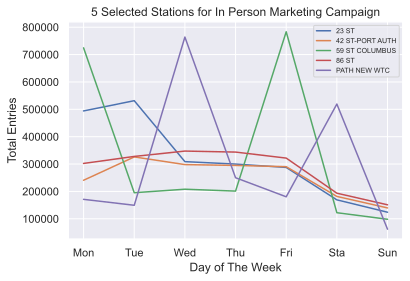

In [30]:
x = df_total_daily_update.DAY_OF_WEEK
y = df_total_daily_update.TOTAL_DAILY_ENTRIES
sns.lineplot(x, y, hue = df_total_daily_update.STATION, data = df_total_daily_update)
plt.title('5 Selected Stations for In Person Marketing Campaign')
plt.xlabel('Day of The Week')
plt.ylabel('Total Entries')
plt.xticks(np.arange(7),['Mon','Tue','Wed','Thu','Fri','Sta','Sun'])
plt.legend(loc=0, prop={'size': 7})
plt.savefig('5_station_for_in_person_crew.png')

In [31]:
#using python code
df_total_daily_update.sort_values(['STATION','TOTAL_DAILY_ENTRIES'], ascending = False).groupby(['STATION']).head(2)

,STATION,DAY_OF_WEEK,TOTAL_DAILY_ENTRIES
30,PATH NEW WTC,2,764015.00000
33,PATH NEW WTC,5,519207.00000
23,86 ST,2,347426.00000
24,86 ST,3,343744.00000
18,59 ST COLUMBUS,4,783324.00000
14,59 ST COLUMBUS,0,724451.00000
8,42 ST-PORT AUTH,1,325998.00000
9,42 ST-PORT AUTH,2,298037.00000
1,23 ST,1,531522.00000
0,23 ST,0,494157.00000


Conclusion 1: placing billboards at
 “34 ST-HERALD SQ”, “FULTON ST”, “GRD CNTRL-42 ST”, “34 ST-PENN STA”, “TIMES SQ-42 ST” (24/7 for 2 whole weeks)
 
Conclusion 2: in person crew at(2 days per week) 
1. “PATH NEW WTC”: Wed & Sat
2. “86 ST”: Wed & Thu
3. “59 ST COLUMBUS”: Mon & Fri
4. “42 ST-PORT AUTH : Tue & Wed
5. “23 ST”: Mon & Tue

# Addition

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Total Entries')

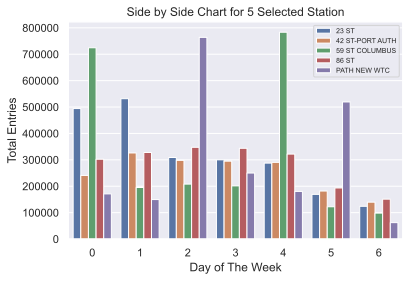

In [32]:
#we can also see the difference between each station for 7 individual day
sns.barplot(x, y, hue=df_total_daily_update.STATION, data = df_total_daily_update)
plt.legend(loc=0, prop={'size': 7})
plt.title('Side by Side Chart for 5 Selected Station')
plt.xlabel('Day of The Week')
plt.ylabel('Total Entries')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Total Entries')

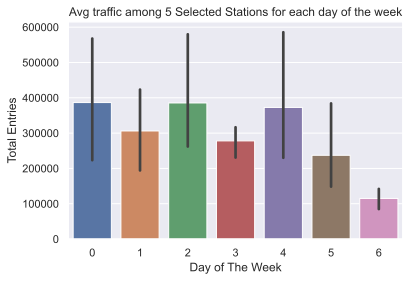

In [33]:
sns.barplot(x, y,  data = df_total_daily_update)
plt.title('Avg traffic among 5 Selected Stations for each day of the week')
plt.xlabel('Day of The Week')
plt.ylabel('Total Entries')